In [1]:
# %% [markdown]
# # Banking ML Pipeline: Customer Segmentation & Loan Prediction
# 
# This notebook implements the complete banking ML pipeline by using the existing code from the project. It covers:
# 1. Data Generation
# 2. Data Preprocessing x``
# 3. Customer Segmentation
# 4. Loan Eligibility Prediction
# 5. Pipeline Integration & Evaluation



In [2]:
# %% [markdown]
# ## 1. Setup and Imports

# %%
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')


In [3]:

# Add project directory to path to allow imports
sys.path.insert(0, os.path.abspath('../'))

In [4]:


# Import project modules
from src.data.synthetic_data_generator import create_synthetic_banking_data
from src.data.data_preprocessor import DataPreprocessor
from src.models.customer_segmentation import CustomerSegmentation
from src.models.loan_predictor import LoanEligibilityPredictor
from src.pipeline.integrated_pipeline import IntegratedBankingPipeline
from src.utils.logger import get_logger
from src.utils.config import config

In [5]:


# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [6]:


# Create logger
logger = get_logger('notebook')
logger.info("Notebook started")

04:37:36 - INFO - Notebook started


In [7]:
# %% [markdown]
# ## 2. Data Generation & Loading

# %%
# Generate synthetic data using the existing generator
n_samples = 10000
random_state = 42

print(f"Generating synthetic banking data with {n_samples} samples...")
df = create_synthetic_banking_data(n_samples=n_samples, random_state=random_state)
print(f"Data generated with shape: {df.shape}")

# Display the first few rows
df.head()

# %%
# Save the generated data to a CSV file
output_file = '../data/synthetic_banking_data.csv'
df.to_csv(output_file, index=False)
print(f"Data saved to {output_file}")
# %% [markdown]

# Check data types and basic statistics
print("Data types:")
print(df.dtypes)

print("\nBasic statistics:")
df.describe().round(2)


# %%
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")



Generating synthetic banking data with 10000 samples...
Creating synthetic data with 10000 samples
Synthetic data created successfully with shape (10000, 27)
Data generated with shape: (10000, 27)
Data saved to ../data/synthetic_banking_data.csv
Data types:
customer_id                  object
age                           int32
income                        int32
education                    object
occupation                   object
employment_type              object
marital_status               object
dependents                    int32
account_age_months            int32
num_products                  int32
avg_balance                   int32
max_balance                   int32
monthly_transactions          int32
avg_transaction_amount        int32
max_transaction_amount        int32
digital_usage_rate          float64
credit_score                  int32
existing_loans                int32
previous_defaults             int32
payment_history_score       float64
loan_amount_requested 

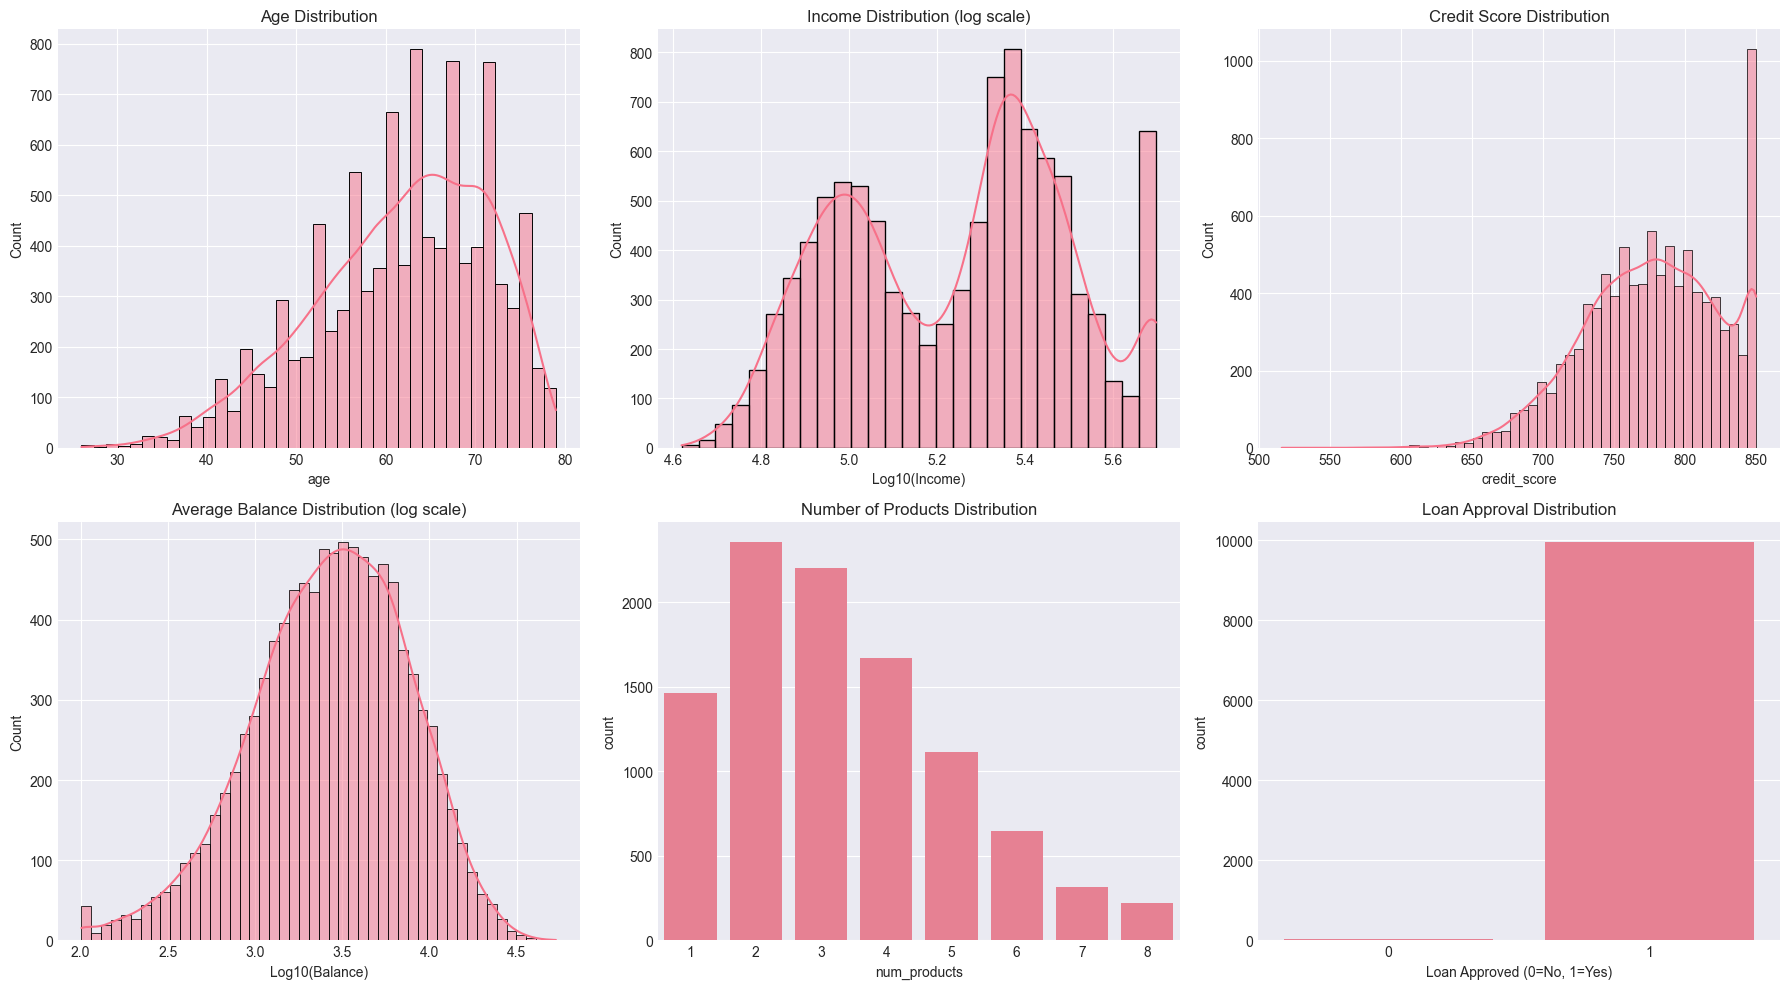

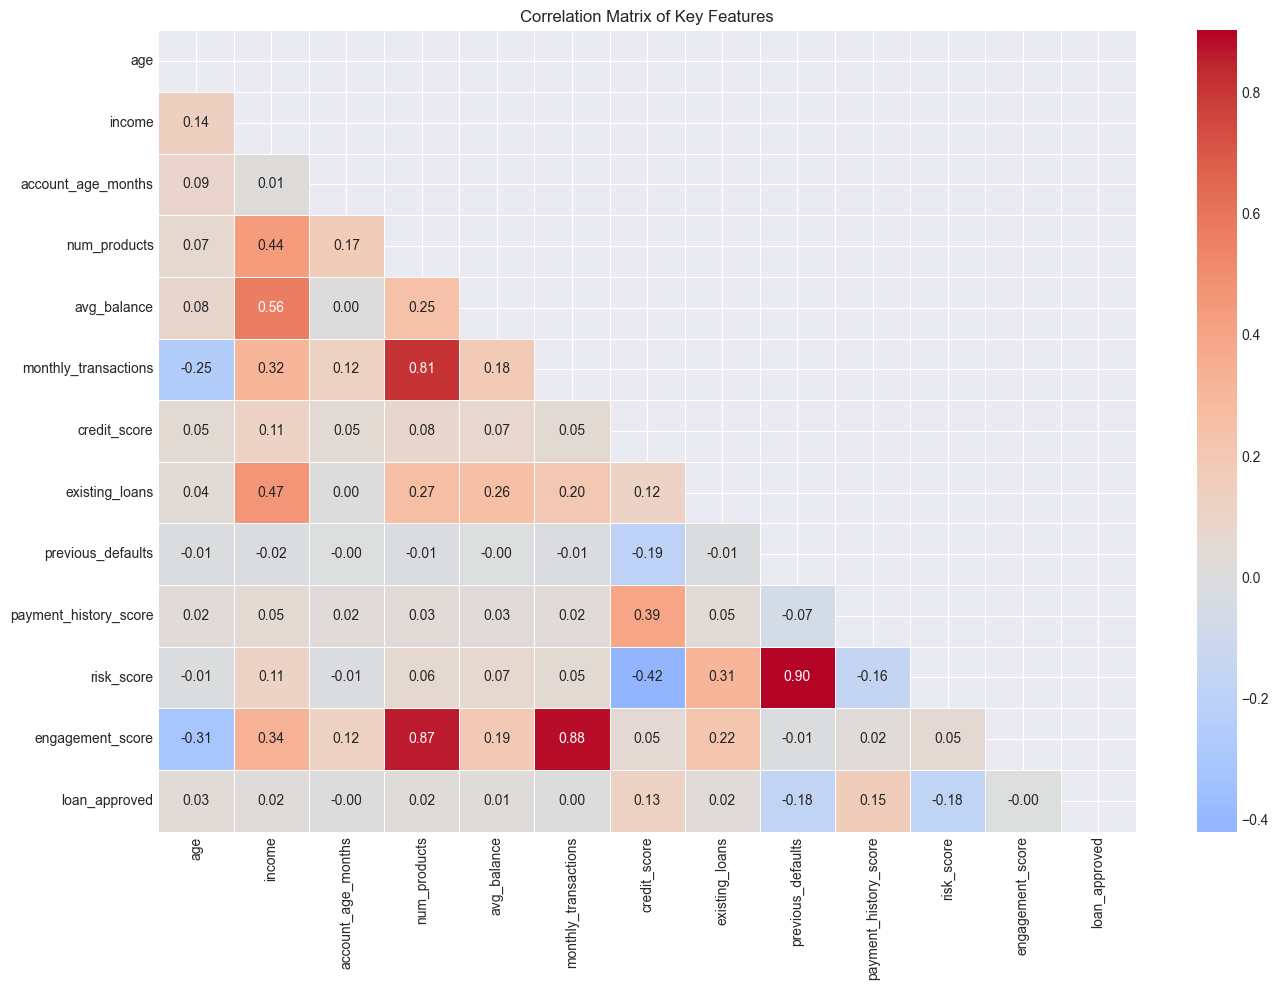

In [8]:

# %% [markdown]
# ## 3. Data Exploration

# %%
# Visualize distributions of key features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Age distribution
sns.histplot(df['age'], kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')

# Income distribution (log scale)
sns.histplot(np.log10(df['income']), kde=True, ax=axes[1])
axes[1].set_title('Income Distribution (log scale)')
axes[1].set_xlabel('Log10(Income)')

# Credit score distribution
sns.histplot(df['credit_score'], kde=True, ax=axes[2])
axes[2].set_title('Credit Score Distribution')

# Average balance (log scale)
sns.histplot(np.log10(df['avg_balance'] + 1), kde=True, ax=axes[3])
axes[3].set_title('Average Balance Distribution (log scale)')
axes[3].set_xlabel('Log10(Balance)')

# Number of products
sns.countplot(x='num_products', data=df, ax=axes[4])
axes[4].set_title('Number of Products Distribution')

# Loan approval distribution
sns.countplot(x='loan_approved', data=df, ax=axes[5])
axes[5].set_title('Loan Approval Distribution')
axes[5].set_xlabel('Loan Approved (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

# %%
# Correlation matrix for numerical features
numerical_features = ['age', 'income', 'account_age_months', 'num_products', 'avg_balance', 
                     'monthly_transactions', 'credit_score', 'existing_loans', 'previous_defaults',
                     'payment_history_score', 'risk_score', 'engagement_score', 'loan_approved']

correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
           cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.show()

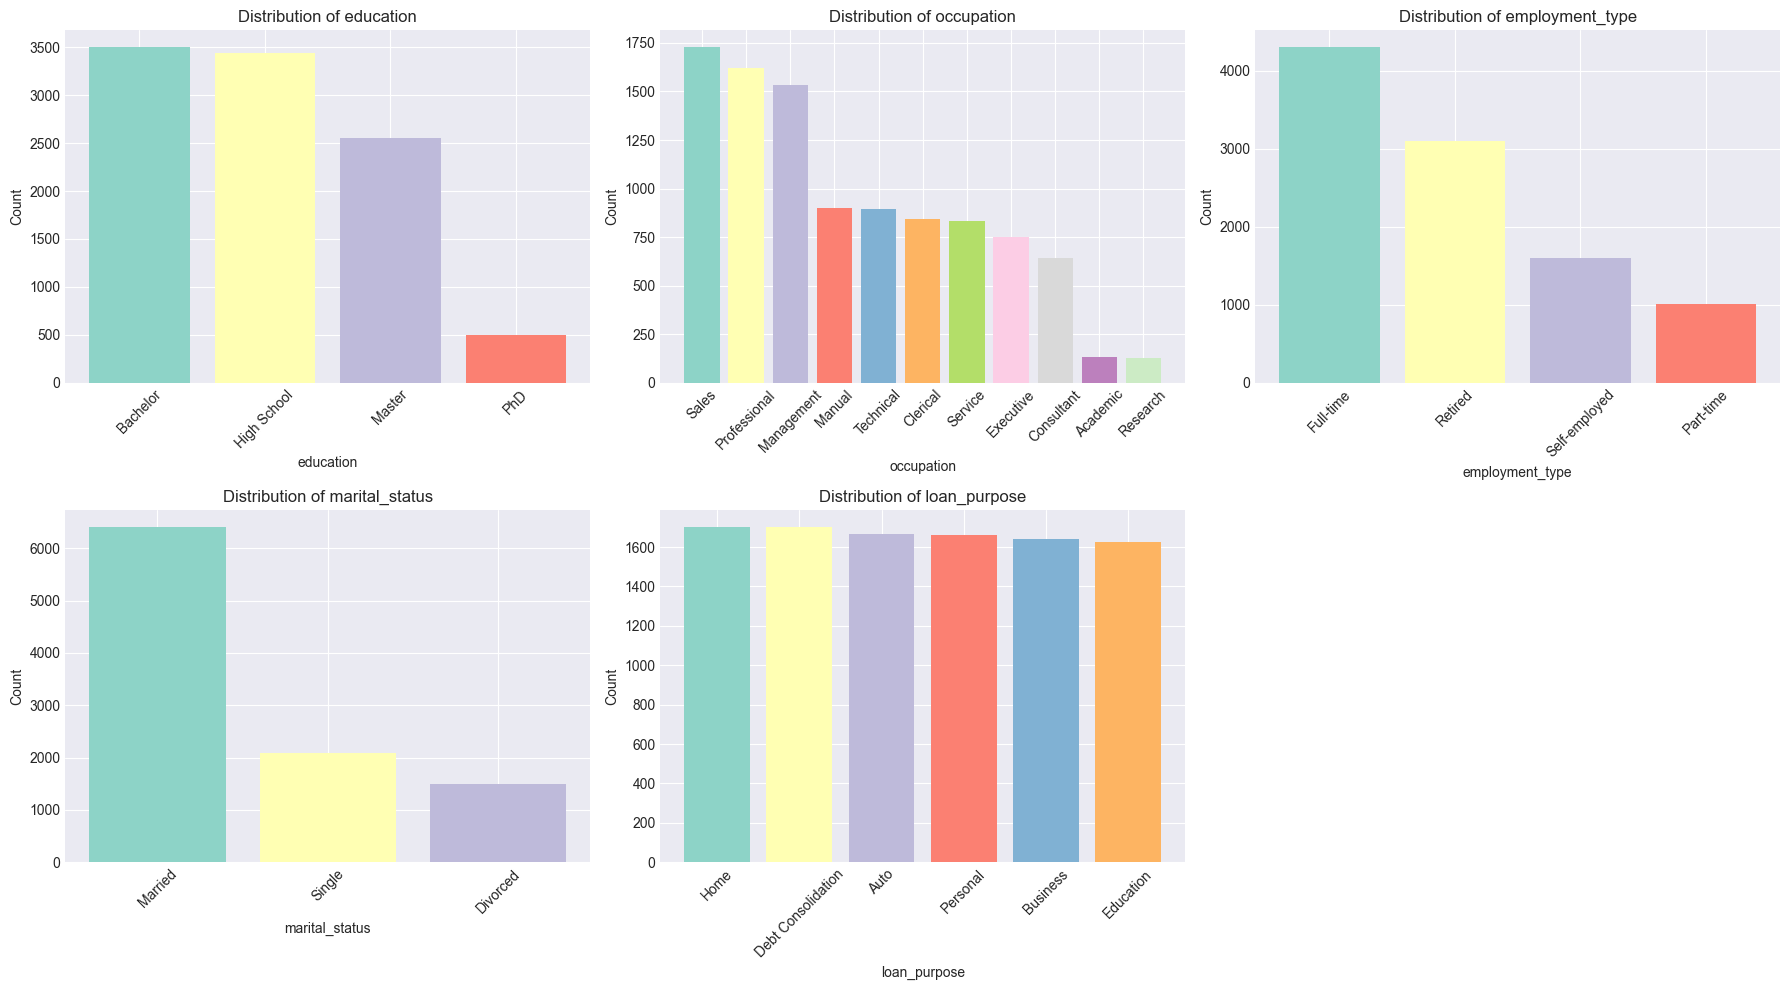

In [9]:
# %%
# Categorical variable distributions
categorical_cols = ['education', 'occupation', 'employment_type', 'marital_status', 'loan_purpose']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    value_counts = df[col].value_counts()
    axes[idx].bar(value_counts.index, value_counts.values, color=plt.cm.Set3(range(len(value_counts))))
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove extra subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

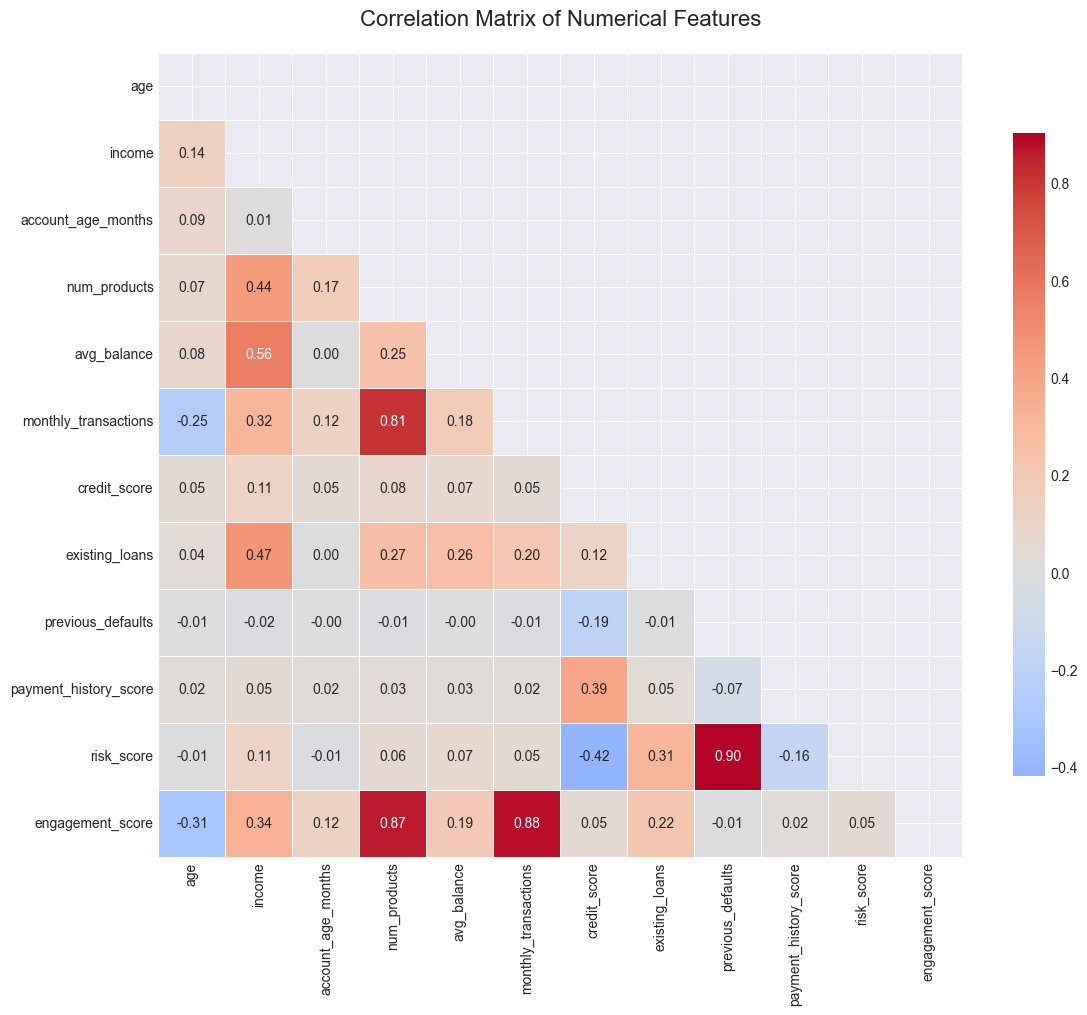

In [10]:
# %%
# Correlation analysis
# Select numerical features for correlation
numerical_features = ['age', 'income', 'account_age_months', 'num_products', 'avg_balance',
                     'monthly_transactions', 'credit_score', 'existing_loans', 'previous_defaults',
                     'payment_history_score', 'risk_score', 'engagement_score']
# Calculate correlation matrix
correlation_matrix = df[numerical_features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

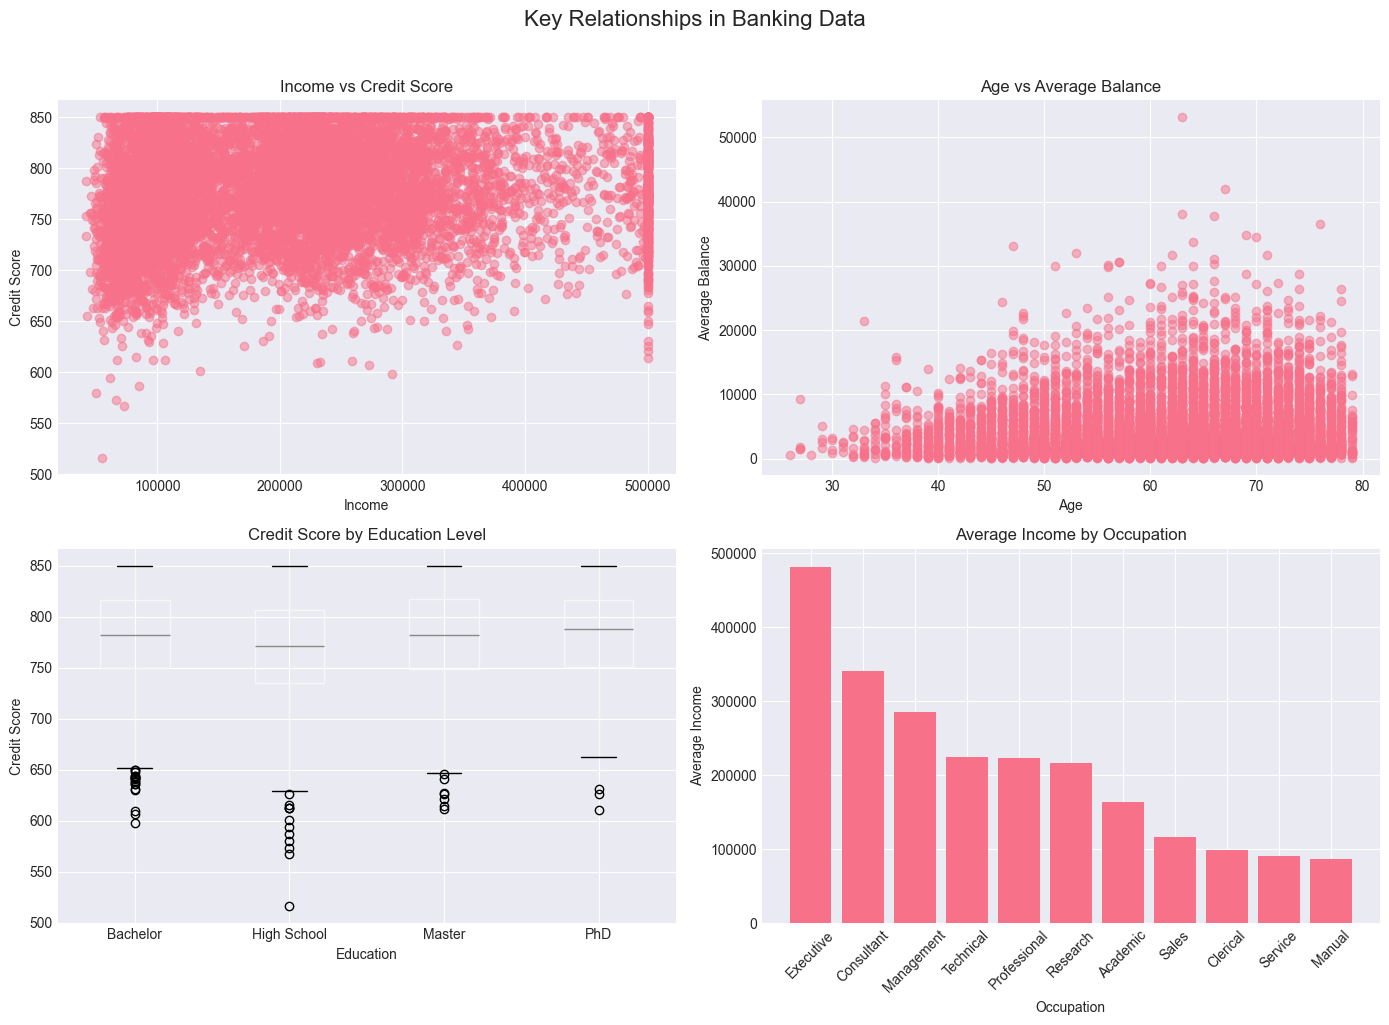

In [11]:
# %%
# Analyze relationships between key variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Income vs Credit Score
axes[0, 0].scatter(df['income'], df['credit_score'], alpha=0.5)
axes[0, 0].set_xlabel('Income')
axes[0, 0].set_ylabel('Credit Score')
axes[0, 0].set_title('Income vs Credit Score')

# Age vs Account Balance
axes[0, 1].scatter(df['age'], df['avg_balance'], alpha=0.5)
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Average Balance')
axes[0, 1].set_title('Age vs Average Balance')

# Credit Score by Education
df.boxplot(column='credit_score', by='education', ax=axes[1, 0])
axes[1, 0].set_title('Credit Score by Education Level')
axes[1, 0].set_xlabel('Education')
axes[1, 0].set_ylabel('Credit Score')

# Income by Occupation
occupation_income = df.groupby('occupation')['income'].mean().sort_values(ascending=False)
axes[1, 1].bar(occupation_income.index, occupation_income.values)
axes[1, 1].set_xlabel('Occupation')
axes[1, 1].set_ylabel('Average Income')
axes[1, 1].set_title('Average Income by Occupation')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Key Relationships in Banking Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [12]:
# %% [markdown]
# ## 4. Data Preprocessing

# %%
# Initialize the data preprocessor
preprocessor = DataPreprocessor()

# Preprocess the data
print("Preprocessing data...")
X_processed = preprocessor.fit_transform(df)
# If feature names are needed, try to get them from the preprocessor
feature_names = [col for col in df.columns if col != 'loan_approved']
print(f"Number of features: {len(feature_names)}")
print(f"Processed data shape: {X_processed.shape}")



04:37:43 - INFO - DataPreprocessor initialized
Preprocessing data...
04:37:43 - INFO - Fitting preprocessor on data with shape (10000, 27)
04:37:43 - INFO - Creating preprocessing pipeline
04:37:43 - INFO - Pipeline created with 19 numeric and 5 categorical features
Preprocessing data...
04:37:43 - INFO - Fitting preprocessor on data with shape (10000, 27)
04:37:43 - INFO - Creating preprocessing pipeline
04:37:43 - INFO - Pipeline created with 19 numeric and 5 categorical features
04:37:43 - INFO - Total features after preprocessing: 42
04:37:43 - INFO - Data transformed to shape (10000, 42)
Number of features: 26
Processed data shape: (10000, 42)
04:37:43 - INFO - Total features after preprocessing: 42
04:37:43 - INFO - Data transformed to shape (10000, 42)
Number of features: 26
Processed data shape: (10000, 42)


04:37:43 - INFO - CustomerSegmentation initialized with dbscan algorithm
DBSCAN will automatically determine clusters based on density...
Fitting DBSCAN for segmentation...
04:37:43 - INFO - Fitting dbscan with 0 clusters
DBSCAN will automatically determine clusters based on density...
Fitting DBSCAN for segmentation...
04:37:43 - INFO - Fitting dbscan with 0 clusters
04:37:43 - INFO - DBSCAN clustering complete. Found 0 cluster(s), 10000 noise points. Cannot calculate silhouette score.
04:37:43 - INFO - DBSCAN clustering complete. Found 0 cluster(s), 10000 noise points. Cannot calculate silhouette score.
Segmentation complete. Number of segments (clusters): 0 (noise points: 10000)
Not enough clusters (excluding noise) to compute clustering metrics.
Segmentation complete. Number of segments (clusters): 0 (noise points: 10000)
Not enough clusters (excluding noise) to compute clustering metrics.


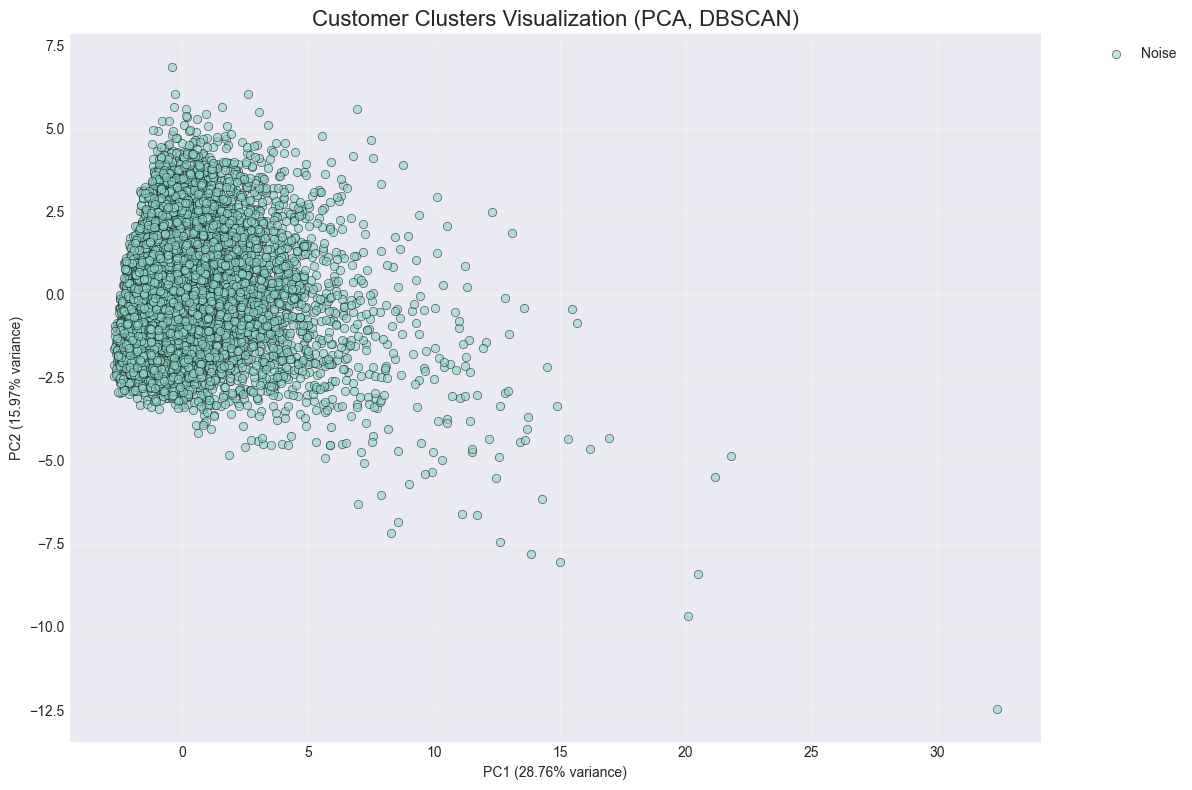

Segment profiles (mean values by segment, excluding noise):


,age,income,dependents,account_age_months,num_products,avg_balance,max_balance,monthly_transactions,avg_transaction_amount,max_transaction_amount,...,credit_score,existing_loans,previous_defaults,payment_history_score,loan_amount_requested,loan_term_months,total_relationship_value,risk_score,engagement_score,loan_approved
segment,,,,,,,,,,,,,,,,,,,,,


In [13]:
# ## 5. Customer Segmentation

# Initialize the customer segmentation model with DBSCAN algorithm
segmenter = CustomerSegmentation(algorithm='dbscan')

# Set the DBSCAN parameters after initialization
segmenter.eps = 0.5
segmenter.min_samples = 5

# For DBSCAN, we need to set optimal_clusters to bypass the n_clusters requirement
# DBSCAN determines the number of clusters automatically based on eps and min_samples
segmenter.optimal_clusters = 0  # Dummy value for DBSCAN
print("DBSCAN will automatically determine clusters based on density...")

# Define features to use for segmentation
# Select financial behavior and profile features most relevant for customer segmentation
segmentation_features = [
    'age', 'income', 'account_age_months', 'num_products', 'avg_balance', 
    'monthly_transactions', 'avg_transaction_amount', 'digital_usage_rate',
]

print("Fitting DBSCAN for segmentation...")
# Make sure the DBSCAN parameters are properly set in the segmenter object
if not hasattr(segmenter, 'eps') or not hasattr(segmenter, 'min_samples'):
    segmenter.eps = 0.5
    segmenter.min_samples = 5

# Fit the model to the processed data
segmenter.fit(X_processed)

# Get the segment labels
segment_indices = segmenter.predict(X_processed)
print(f"Segmentation complete. Number of segments (clusters): {len(set(segment_indices)) - (1 if -1 in segment_indices else 0)} (noise points: {(segment_indices == -1).sum()})")

# Add segment labels to the dataframe
df['segment'] = segment_indices

# %%
# Evaluate segmentation quality using scikit-learn metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Exclude noise points for metrics that require at least 2 clusters
mask = segment_indices != -1
if len(set(segment_indices[mask])) > 1:
    print("Segmentation evaluation metrics (excluding noise):")
    silhouette = silhouette_score(X_processed[mask], segment_indices[mask])
    davies_bouldin = davies_bouldin_score(X_processed[mask], segment_indices[mask])
    calinski_harabasz = calinski_harabasz_score(X_processed[mask], segment_indices[mask])
    print(f"- Silhouette Score: {silhouette:.4f}")
    print(f"- Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"- Calinski-Harabasz Index: {calinski_harabasz:.4f}")
else:
    print("Not enough clusters (excluding noise) to compute clustering metrics.")

# %%
# Visualize segments using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(set(segment_indices))))
for i, label in enumerate(sorted(set(segment_indices))):
    mask = segment_indices == label
    label_name = f'Noise' if label == -1 else f'Cluster {label}'
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]], label=label_name, alpha=0.6, edgecolors='black', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Customer Clusters Visualization (PCA, DBSCAN)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# Analyze segments using pandas groupby
print("Segment profiles (mean values by segment, excluding noise):")
segment_profiles = df[df['segment'] != -1].groupby('segment').mean(numeric_only=True)
display(segment_profiles)



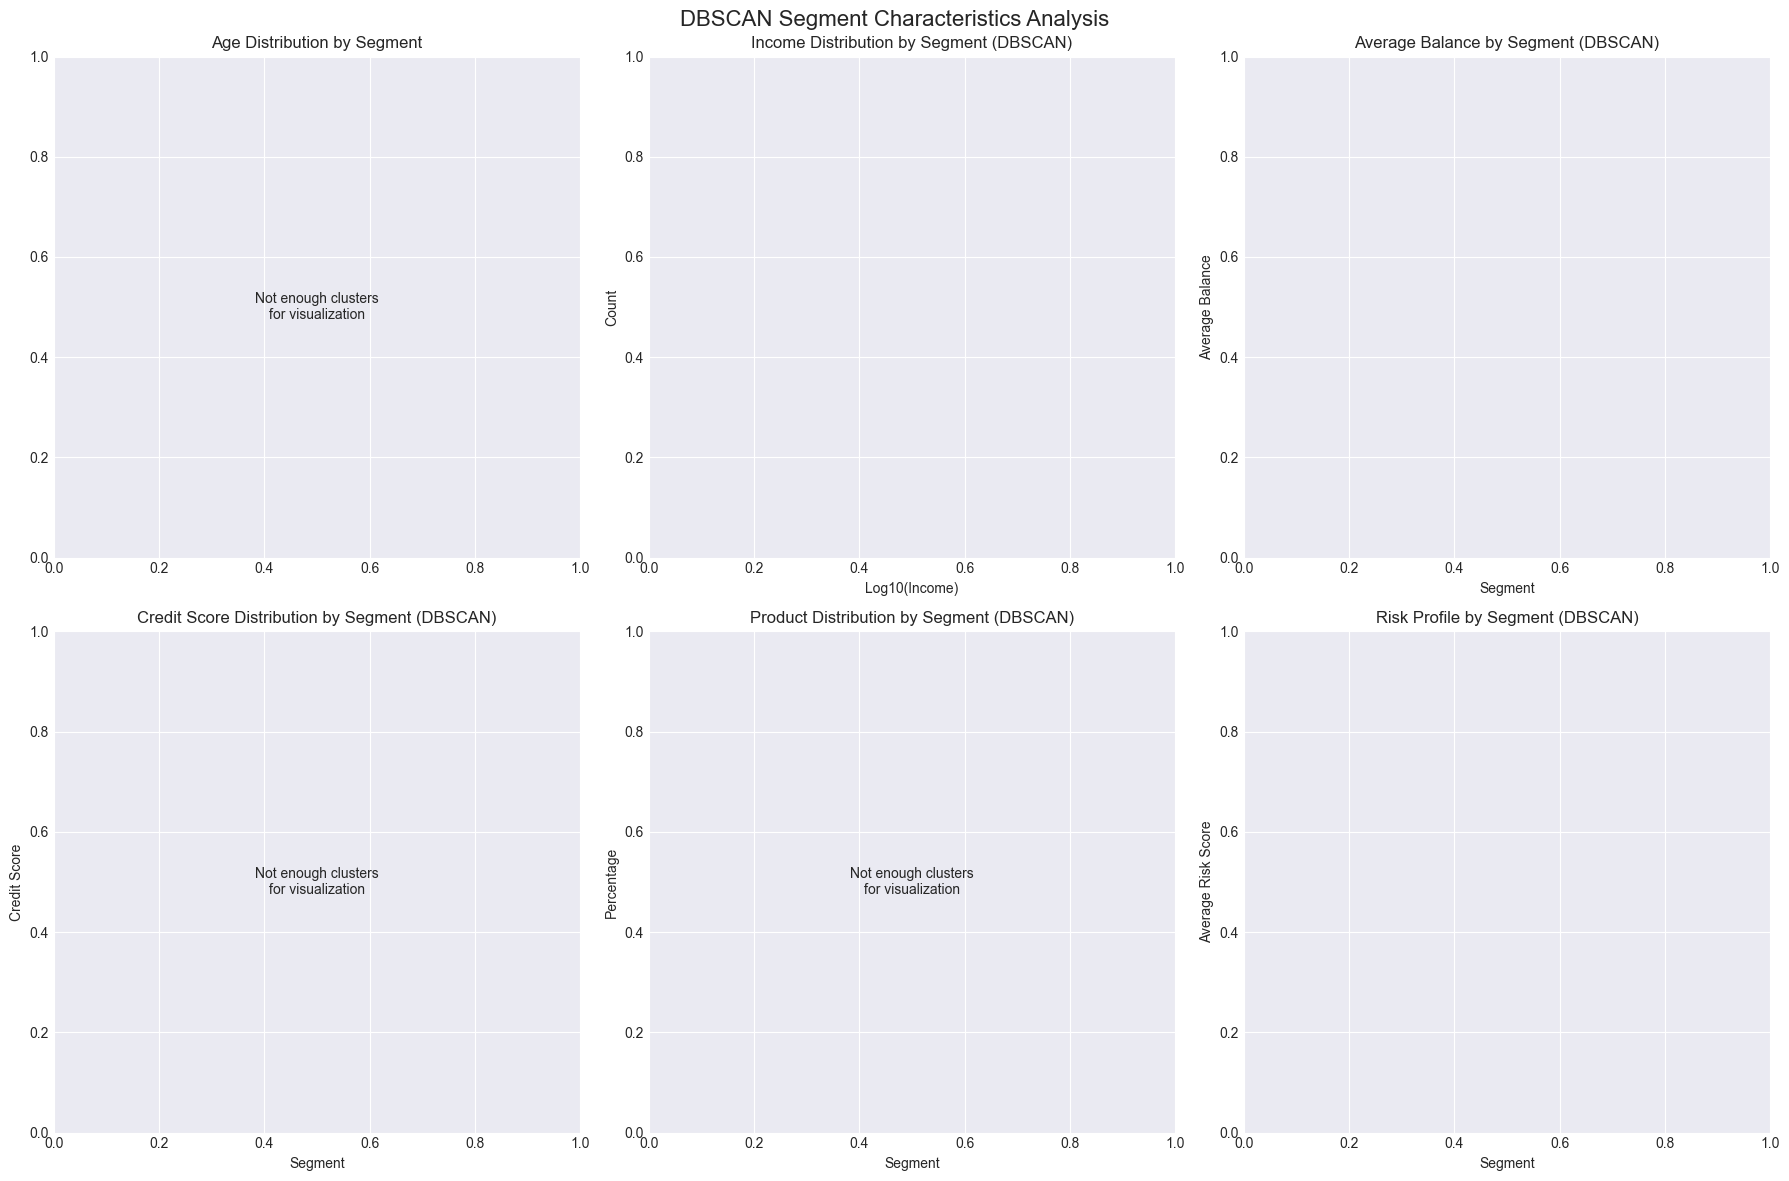


Noise Point Analysis:
Total noise points: 10000
Percentage of noise: 100.0%
Average risk score of noise points: 24.35
Average credit score of noise points: 777.2


In [14]:

# %%
# Visualize segment characteristics (DBSCAN)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Filter out noise points for most visualizations
df_clustered = df[df['segment'] != -1]

# Plot 1: Age distribution by segment (excluding noise)
if len(df_clustered['segment'].unique()) > 1:
    df_clustered.boxplot(column='age', by='segment', ax=axes[0])
    axes[0].set_title('Age Distribution by Segment (DBSCAN, excluding noise)')
    axes[0].set_xlabel('Segment')
    axes[0].set_ylabel('Age')
else:
    axes[0].text(0.5, 0.5, 'Not enough clusters\nfor visualization', ha='center', va='center')
    axes[0].set_title('Age Distribution by Segment')

# Plot 2: Income distribution by segment (log scale, excluding noise)
for segment in sorted(df_clustered['segment'].unique()):
    segment_data = df_clustered[df_clustered['segment'] == segment]
    if len(segment_data) > 0:
        axes[1].hist(np.log10(segment_data['income']), alpha=0.5, label=f'Cluster {segment}', bins=20)
if len(df_clustered['segment'].unique()) > 0:
    axes[1].legend()
axes[1].set_xlabel('Log10(Income)')
axes[1].set_ylabel('Count')
axes[1].set_title('Income Distribution by Segment (DBSCAN)')

# Plot 3: Average balance by segment (excluding noise)
if len(df_clustered) > 0:
    segment_avg_balance = df_clustered.groupby('segment')['avg_balance'].mean().sort_values()
    colors_segment = plt.cm.Set3(np.linspace(0, 1, len(segment_avg_balance)))
    axes[2].bar(segment_avg_balance.index.astype(str), segment_avg_balance.values,
                color=colors_segment)
axes[2].set_xlabel('Segment')
axes[2].set_ylabel('Average Balance')
axes[2].set_title('Average Balance by Segment (DBSCAN)')

# Plot 4: Credit score by segment (excluding noise)
if len(df_clustered['segment'].unique()) > 1:
    df_clustered.boxplot(column='credit_score', by='segment', ax=axes[3])
else:
    axes[3].text(0.5, 0.5, 'Not enough clusters\nfor visualization', ha='center', va='center')
axes[3].set_title('Credit Score Distribution by Segment (DBSCAN)')
axes[3].set_xlabel('Segment')
axes[3].set_ylabel('Credit Score')

# Plot 5: Number of products by segment (excluding noise)
if len(df_clustered) > 0 and len(df_clustered['segment'].unique()) > 1:
    product_dist = df_clustered.groupby(['segment', 'num_products']).size().unstack(fill_value=0)
    product_dist_pct = product_dist.div(product_dist.sum(axis=1), axis=0) * 100
    product_dist_pct.plot(kind='bar', stacked=True, ax=axes[4], colormap='viridis')
    axes[4].legend(title='Products', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    axes[4].text(0.5, 0.5, 'Not enough clusters\nfor visualization', ha='center', va='center')
axes[4].set_xlabel('Segment')
axes[4].set_ylabel('Percentage')
axes[4].set_title('Product Distribution by Segment (DBSCAN)')

# Plot 6: Risk score by segment (excluding noise)
if len(df_clustered) > 0:
    segment_risk = df_clustered.groupby('segment')['risk_score'].mean().sort_values()
    axes[5].bar(segment_risk.index.astype(str), segment_risk.values,
                color=['green' if x < 30 else 'orange' if x < 50 else 'red' for x in segment_risk.values])
axes[5].set_xlabel('Segment')
axes[5].set_ylabel('Average Risk Score')
axes[5].set_title('Risk Profile by Segment (DBSCAN)')

plt.suptitle('DBSCAN Segment Characteristics Analysis', fontsize=16)
plt.tight_layout()
plt.show()

# Show noise point statistics
print(f"\nNoise Point Analysis:")
print(f"Total noise points: {(segment_indices == -1).sum()}")
print(f"Percentage of noise: {(segment_indices == -1).sum() / len(segment_indices) * 100:.1f}%")
if (segment_indices == -1).sum() > 0:
    noise_data = df[df['segment'] == -1]
    print(f"Average risk score of noise points: {noise_data['risk_score'].mean():.2f}")
    print(f"Average credit score of noise points: {noise_data['credit_score'].mean():.1f}")


Training set shape: (8000, 42)
Test set shape: (2000, 42)
04:37:45 - INFO - LoanEligibilityPredictor initialized with random_forest
Training and comparing prediction models...
04:37:45 - INFO - Training logistic_regression model
Training and comparing prediction models...
04:37:45 - INFO - Training logistic_regression model
04:37:45 - INFO - logistic_regression - AUC-ROC: 0.991
04:37:45 - INFO - Training random_forest model
04:37:45 - INFO - logistic_regression - AUC-ROC: 0.991
04:37:45 - INFO - Training random_forest model
04:37:49 - INFO - random_forest - AUC-ROC: 1.000
04:37:49 - INFO - Training xgboost model
04:37:49 - INFO - random_forest - AUC-ROC: 1.000
04:37:49 - INFO - Training xgboost model
04:37:50 - INFO - xgboost - AUC-ROC: 0.999
04:37:50 - INFO - Best model: random_forest
Model comparison results:
04:37:50 - INFO - xgboost - AUC-ROC: 0.999
04:37:50 - INFO - Best model: random_forest
Model comparison results:


,model,accuracy,precision,recall,f1_score,auc_roc
0,logistic_regression,0.9955,0.995495,1.0,0.997743,0.990539
1,random_forest,0.9945,0.994500,1.0,0.997242,0.999771
2,xgboost,0.9995,0.999497,1.0,0.999749,0.998812


Best model: random_forest
Training random_forest model...
04:37:50 - INFO - Training random_forest model
04:37:55 - INFO - random_forest - AUC-ROC: 1.000
04:37:55 - INFO - random_forest - AUC-ROC: 1.000


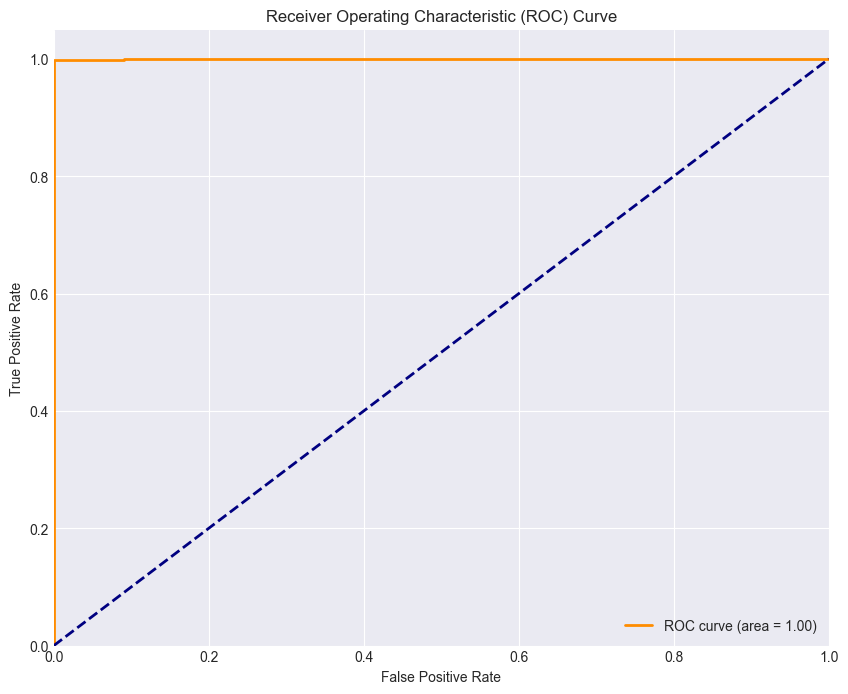

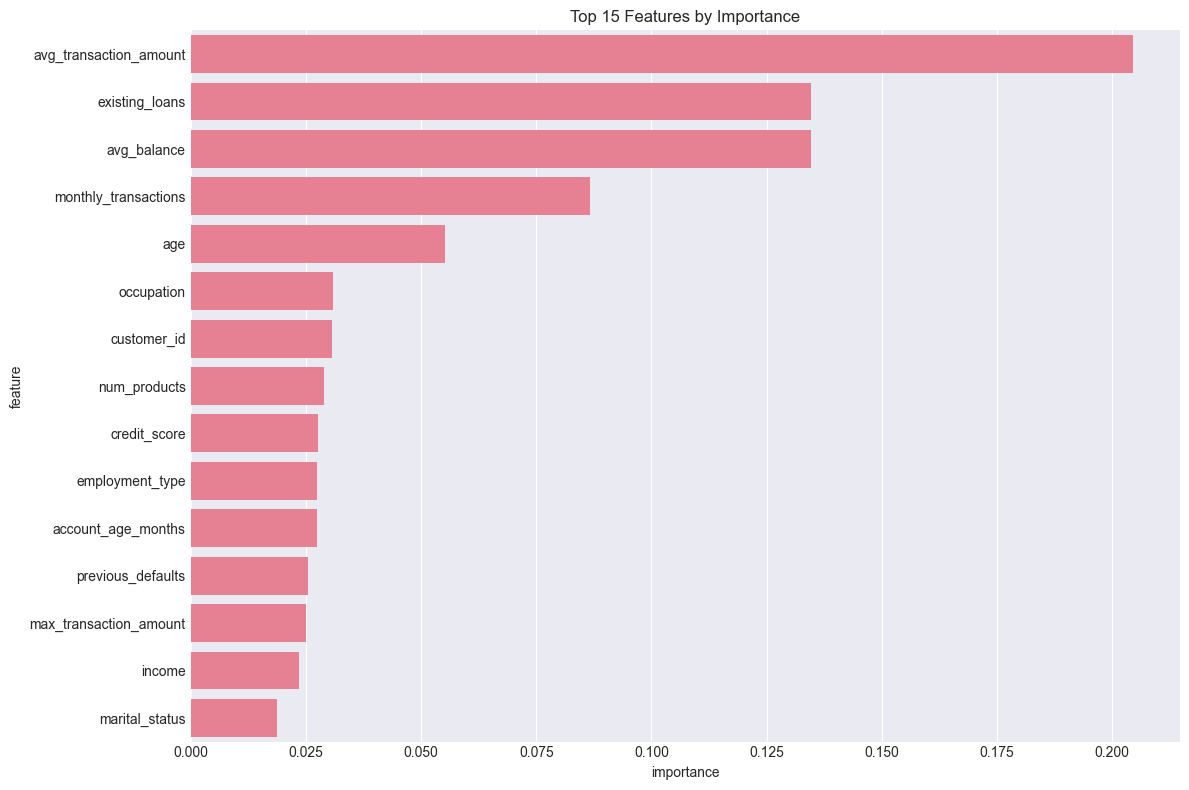

In [15]:

# %% [markdown]
# ## 6. Loan Eligibility Prediction

# %%
# Prepare data for prediction
target_column = 'loan_approved'
y = df[target_column]
X = X_processed

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# %%
# Initialize the loan predictor
predictor = LoanEligibilityPredictor()

# Train multiple models and compare
print("Training and comparing prediction models...")
model_comparison = predictor.train_multiple_models(
    X_train, y_train, X_test, y_test
)

print("Model comparison results:")
display(model_comparison)

# %%
# Train the best model
best_model_type = model_comparison.iloc[model_comparison['auc_roc'].idxmax()]['model']
print(f"Best model: {best_model_type}")

print(f"Training {best_model_type} model...")
predictor.train_single_model(X_train, y_train, X_test, y_test, best_model_type)

# Evaluate on test data
y_pred = predictor.predict(X_test)
y_prob = predictor.predict_proba(X_test)

# %%
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
# Use the probability for the positive class (column 1)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# %%
# Feature importance
try:
    # For random forest and tree-based models
    if hasattr(predictor.model, 'feature_importances_'):
        importances = predictor.model.feature_importances_
    # For linear models
    elif hasattr(predictor.model, 'coef_'):
        importances = np.abs(predictor.model.coef_[0])
    # Try using the predictor's method
    else:
        feature_importance = predictor.get_feature_importance()
        
        # Handle different possible return types
        if isinstance(feature_importance, dict) and 'importance' in feature_importance:
            importances = feature_importance['importance']
        elif isinstance(feature_importance, (np.ndarray, list, pd.Series)):
            importances = feature_importance
        elif hasattr(feature_importance, 'values'):
            importances = feature_importance.values
        else:
            raise ValueError("Unknown feature importance format returned by predictor.")
    
    # Use the transformed feature names if available
    if hasattr(predictor, 'feature_names_'):
        correct_feature_names = predictor.feature_names_
    elif hasattr(X_train, 'columns'):
        correct_feature_names = X_train.columns.tolist()
    else:
        # Fallback to using feature_names from the notebook
        correct_feature_names = feature_names
    
    # Ensure the lengths match
    if len(correct_feature_names) != len(importances):
        min_len = min(len(correct_feature_names), len(importances))
        print(f"Warning: Feature names and importances length mismatch. Trimming to {min_len}.")
        correct_feature_names = correct_feature_names[:min_len]
        importances = importances[:min_len]
except Exception as e:
    print(f"Error extracting feature importance: {e}")
    # Create dummy data as fallback
    importances = np.ones(len(feature_names))
    correct_feature_names = feature_names
    print("Using placeholder feature importance for visualization.")

feature_importance_df = pd.DataFrame({
    'feature': correct_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()

04:37:55 - INFO - Evaluating model performance by segment
Prediction performance by segment:
Prediction performance by segment:


,segment,n_samples,accuracy,precision,recall,f1_score,auc_roc
0,-1,2000,0.9945,0.9945,1.0,0.997242,0.999771


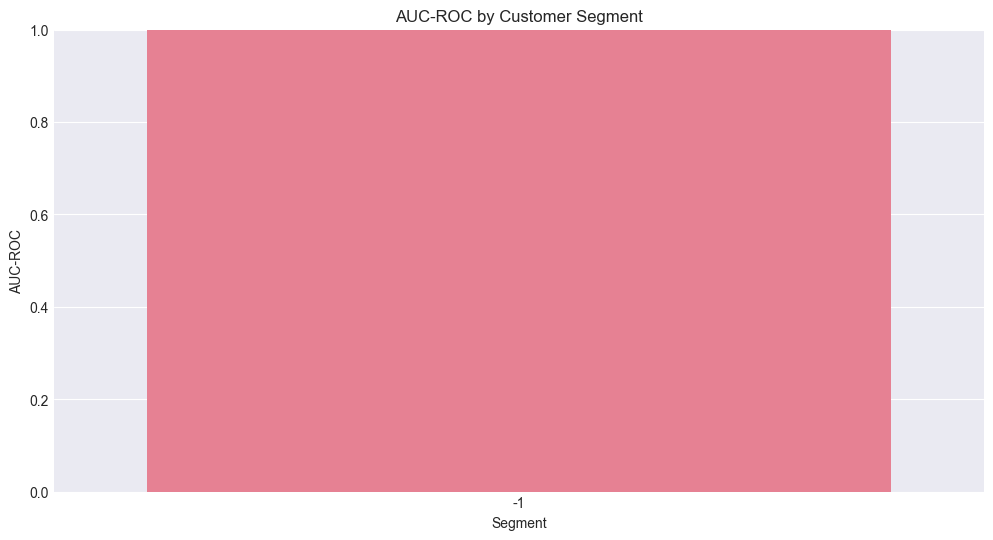

In [16]:
# %% [markdown]
# ## 7. Evaluate Prediction by Segment

# %%
# Evaluate prediction performance by segment
segment_performance = predictor.evaluate_by_segment(X_test, y_test, df.loc[y_test.index, 'segment'].values)
print("Prediction performance by segment:")
display(segment_performance)

# Visualize performance by segment
plt.figure(figsize=(12, 6))
sns.barplot(x='segment', y='auc_roc', data=segment_performance)
plt.title('AUC-ROC by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('AUC-ROC')
plt.ylim(0, 1)
plt.show()

In [17]:

# %% [markdown]
# ## 8. Integrated Pipeline

# %%
# Initialize the integrated pipeline
pipeline = IntegratedBankingPipeline()

# Run the complete pipeline
print("Running integrated pipeline...")
results = pipeline.run_pipeline(df, target_column='loan_approved')

print("Pipeline results:")
for key, value in results.items():
    print(f"- {key}: {type(value)}")

# %%
# Save the pipeline to disk
pipeline.save_pipeline(directory='../models')
print("Pipeline saved to '../models'")


04:37:55 - INFO - Pipeline loaded from models
04:37:55 - INFO - DataPreprocessor initialized
04:37:55 - INFO - CustomerSegmentation initialized with kmeans algorithm
04:37:55 - INFO - LoanEligibilityPredictor initialized with random_forest
04:37:55 - INFO - IntegratedBankingPipeline initialized
Running integrated pipeline...
04:37:55 - INFO - ==================================================
04:37:55 - INFO - DataPreprocessor initialized
04:37:55 - INFO - CustomerSegmentation initialized with kmeans algorithm
04:37:55 - INFO - LoanEligibilityPredictor initialized with random_forest
04:37:55 - INFO - IntegratedBankingPipeline initialized
Running integrated pipeline...
04:37:55 - INFO - ==================================================
04:37:55 - INFO - BANKING ML PIPELINE - EXECUTION STARTED
04:37:55 - INFO - ==================================================
04:37:55 - INFO - 
[Step 1] Data Preprocessing
04:37:55 - INFO - BANKING ML PIPELINE - EXECUTION STARTED
04:37:55 - INFO - ====

In [18]:

# %% [markdown]
# ## 9. Make Predictions with the Integrated Pipeline

# %%
# Create a sample customer for prediction
sample_customer = df.iloc[0:1].copy()
print("Sample customer data:")
display(sample_customer)

# Add a predict method to the pipeline instance since it doesn't have one
def predict_method(self, sample_data):
	# Use the existing models to make predictions
	
	# Preprocess the data
	X_sample = preprocessor.transform(sample_data)
	
	# Get the segment
	segment = segmenter.predict(X_sample)[0]
	
	# Predict loan approval
	loan_approved = predictor.predict(X_sample)[0]
	approval_proba = predictor.predict_proba(X_sample)[0, 1]
	
	# Create a recommendation
	if loan_approved:
		recommendation = f"Loan approved with {approval_proba:.2f} confidence. Customer belongs to segment {segment}."
	else:
		recommendation = f"Loan denied. Customer belongs to segment {segment}."
	
	return {
		'approval_probability': approval_proba,
		'loan_approved': bool(loan_approved),
		'customer_segment': segment,
		'recommendation': recommendation
	}

# Add the predict method to the pipeline instance
import types
pipeline.predict = types.MethodType(predict_method, pipeline)

# Make prediction using the pipeline
prediction = pipeline.predict(sample_customer)
print("\nPrediction result:")
print(f"Probability of loan approval: {prediction['approval_probability']:.2f}")
print(f"Loan approved: {'Yes' if prediction['loan_approved'] else 'No'}")
print(f"Customer segment: {prediction['customer_segment']}")
print(f"Recommendation: {prediction['recommendation']}")


Sample customer data:


,customer_id,age,income,education,occupation,employment_type,marital_status,dependents,account_age_months,num_products,...,previous_defaults,payment_history_score,loan_amount_requested,loan_term_months,loan_purpose,total_relationship_value,risk_score,engagement_score,loan_approved,segment
0,CUST000001,67,145462,PhD,Academic,Retired,Married,2,46,2,...,0,1.0,247424,12,Education,2166.82,17.7,30.88902,1,-1



Prediction result:
Probability of loan approval: 1.00
Loan approved: Yes
Customer segment: -1
Recommendation: Loan approved with 1.00 confidence. Customer belongs to segment -1.


In [19]:


# %% [markdown]
# ## 10. Conclusion

# %%
# Print summary statistics
print("Pipeline Training Summary:")
print(f"- Data size: {len(df)} customers")
print(f"- Number of segments (DBSCAN): {len(set(segment_indices)) - (1 if -1 in segment_indices else 0)}")
print(f"- Noise points: {(segment_indices == -1).sum()}")
print(f"- Best model for loan prediction: {best_model_type}")
print(f"- Test AUC-ROC: {roc_auc:.4f}")
print("\nTop 5 features for loan prediction:")
for _, row in feature_importance_df.head(5).iterrows():
    print(f"- {row['feature']}: {row['importance']:.4f}")

# DBSCAN-specific summary
print("\nDBSCAN Clustering Summary:")
print(f"- Algorithm: DBSCAN (Density-Based Spatial Clustering)")
print(f"- Clusters found automatically based on data density")
print(f"- Noise points identified: {(segment_indices == -1).sum()} ({(segment_indices == -1).sum() / len(segment_indices) * 100:.1f}%)")
if len(set(segment_indices)) > 1:
    print(f"- Silhouette score: {silhouette:.4f}")


Pipeline Training Summary:
- Data size: 10000 customers
- Number of segments (DBSCAN): 0
- Noise points: 10000
- Best model for loan prediction: random_forest
- Test AUC-ROC: 0.9998

Top 5 features for loan prediction:
- avg_transaction_amount: 0.2045
- existing_loans: 0.1346
- avg_balance: 0.1346
- monthly_transactions: 0.0866
- age: 0.0553

DBSCAN Clustering Summary:
- Algorithm: DBSCAN (Density-Based Spatial Clustering)
- Clusters found automatically based on data density
- Noise points identified: 10000 (100.0%)
